### Install the beacon_api package to interact with the Beacon Data Lake API

You can find the package on PyPI: https://pypi.org/project/beacon-api/

If you run into any issues, please refer to the GitHub repository: https://github.com/maris-development/beacon

Documentation for the beacon_api package can be found here: https://maris-development.github.io/beacon/docs/1.2.0/query-docs/getting-started.html#python

Documentation for the Beacon Data Lake technology can be found here: https://maris-development.github.io/beacon/

In [1]:
%pip install beacon_api --upgrade
from beacon_api import * # Import the Beacon API client
import os

Note: you may need to restart the kernel to use updated packages.


#### In order to get access to the Beacon endpoint, you will need a token.

The notebook will fetch the Token for you when running in the D4science VRE.
If you are running the notebook outside the D4Science VRE you will need to get the token from the D4science VRE and fill it in manually.

In [ ]:
TOKEN = os.getenv('D4SCIENCE_TOKEN') # This will fetch the token from the VRE environment.
# If you want to run this notebook locally, you can set the TOKEN variable directly here:
#TOKEN = "" # Get your token from https://blue-cloud.d4science.org/group/blue-cloudlab/authorization. Simply press "Get Token" and copy the token here.
BEACON_INSTANCE_URL = "https://beacon-wod.maris.nl" # Can optionally be replaced with the Beacon running on D4Science: https://beacon-argo.d4science.org

#### Connect to the Beacon Data Lake

In [3]:
if TOKEN is None:
    raise ValueError("TOKEN is not set. Please set the TOKEN variable with your actual token.")
client = Client(BEACON_INSTANCE_URL, jwt_token=TOKEN)

Connected to: https://beacon-wod.maris.nl/ server successfully


#### List the available columns and their data types (e.g., string, integer) that can be queried.

In [4]:
available_columns = client.available_columns_with_data_type()
# Search for all available columns where the column name contains a specific keyword or part of it
search_keyword = "wmo"
matching_columns = [col.name for col in available_columns if search_keyword.lower() in col.name.lower()]
matching_columns

['WMO_ID', 'WMO_ID.long_name']

#### Build a query

In [ ]:
# Input parameters
regionname = f"Med"
BDI = "WOD"
mindate = "2000-01-01T00:00:00"  # yyyy-mm-dd
maxdate = "2015-01-01T00:00:00"  # yyyy-mm-dd
minlon = -8
maxlon = 36.5
minlat = 30
maxlat = 46
AOI_POLY = [
    (-9.50, 30.00),
    (-9.50, 39.00),
    (-0.80, 43.20),
    (16.00, 46.50),
    (36.50, 38.00),
    (36.50, 30.00),
    (-9.50, 30.00)
]
mindepth = 0
maxdepth = 150
format = "pandas" # Options are: pandas, geopandas, netcdf, zarr, parquet, geoparquet, odv, arrow, csv
output_file_name = f"{BDI}_{regionname}"
df = None
gdf = None

# Here we build the query step by step. First we select the columns we want to retrieve, then we add the filters and finally we specify the output format.
query_builder = client.query()

query_builder.add_select_column("wod_unique_cast") 
query_builder.add_select_column("Platform", alias="PLATFORM") 
query_builder.add_select_column("Institute", alias="INSTITUTE") 
query_builder.add_select_column("Temperature", alias="TEMPERATURE")
query_builder.add_select_column("Temperature_WODflag", alias="TEMPERATURE_QC")
query_builder.add_select_column("Temperature_WODprofileflag", alias="TEMPERATURE_PRQC")
query_builder.add_select_column("Salinity", alias="SALINITY")
query_builder.add_select_column("Salinity_WODflag", alias="SALINITY_QC")
query_builder.add_select_column("Salinity_WODprofileflag", alias="SALINITY_PRQC")
query_builder.add_select_column("z", alias="DEPTH")
query_builder.add_select_column("z_WODflag", alias="DEPTH_QC")
query_builder.add_select_column("time", alias="TIME") 
query_builder.add_select_column("time.units") 
query_builder.add_select_column("lon", alias="LONGITUDE")
query_builder.add_select_column("lat", alias="LATITUDE")
query_builder.add_select_column("dataset", alias="DATASET")
query_builder.add_select_column("WMO_ID", alias = "WMO_UNIQUE_CAST")

## Add the filters
query_builder.add_range_filter("TIME", mindate, maxdate)  # You can adjust the date range as needed. The format is ISO 8601.
query_builder.add_range_filter("LONGITUDE", minlon, maxlon)  # Longitude range
query_builder.add_range_filter("LATITUDE", minlat, maxlat)  # Latitude range from -90 to 90 (you can adjust as needed)
query_builder.add_polygon_filter("LONGITUDE","LATITUDE", AOI_POLY)  # Define a polygon area (you can adjust the coordinates as needed)
query_builder.add_is_not_null_filter("TEMPERATURE")  # Ensure Temperature is not null
query_builder.add_equals_filter("TEMPERATURE_QC", 0.0)  # Only good quality temperature
query_builder.add_equals_filter("TEMPERATURE_PRQC", 0.0)  # Only good quality temperature
query_builder.add_is_not_null_filter("SALINITY")  # Ensure Salinity is not
query_builder.add_equals_filter("SALINITY_QC", 0.0)  # Only good quality salinity
query_builder.add_equals_filter("SALINITY_PRQC", 0.0)  # Only good quality salinity
query_builder.add_is_not_null_filter("DEPTH")  # Ensure Depth is not null
query_builder.add_equals_filter("DEPTH_QC", 0.0)  # Only good quality
query_builder.add_range_filter("DEPTH", mindepth, maxdepth)  # Depth range from 0 to 2000 meters (you can adjust as needed)

# Add the output format
if format == "pandas":
    df = query_builder.to_pandas_dataframe()
elif format == "geopandas":
    gdf = query_builder.to_geo_pandas_dataframe(longitude_column="LONGITUDE", latitude_column="LATITUDE")
elif format == "netcdf":
    query_builder.to_netcdf(output_file_name + ".nc")
elif format == "zarr":
    query_builder.to_zarr(output_file_name + ".zarr")
elif format == "parquet":
    query_builder.to_parquet(output_file_name + ".parquet")
elif format == "geoparquet":
    query_builder.to_geoparquet(output_file_name + ".parquet", longitude_column="LONGITUDE", latitude_column="LATITUDE")
elif format == "odv":
    odv_output = Odv(
        longitude_column=OdvDataColumn("LONGITUDE"),
        latitude_column=OdvDataColumn("LATITUDE"),
        time_column=OdvDataColumn("TIME"),
        depth_column=OdvDataColumn("DEPTH", qf_column="DEPTH_QC"),
        data_columns=[
            OdvDataColumn("TEMPERATURE", qf_column="TEMPERATURE_QC"),
            OdvDataColumn("SALINITY", qf_column="SALINITY_QC"),
        ],
        metadata_columns=[
            OdvDataColumn("WMO_UNIQUE_CAST"),
            OdvDataColumn("INSTITUTE"),
            OdvDataColumn("PLATFORM"),
            OdvDataColumn("DATASET"),
            OdvDataColumn("TEMPERATURE_PRQC"),
            OdvDataColumn("SALINITY_PRQC"),
        ],
        qf_schema="SEADATANET",
        key_column="wod_unique_cast"
    )
    query_builder.to_odv(odv_output, output_file_name + ".zip")
elif format == "arrow":
    query_builder.to_arrow(output_file_name + ".arrow")
elif format == "csv":
    query_builder.to_csv(output_file_name + ".csv")

Running query: {"from": "default", "select": [{"column": "wod_unique_cast", "alias": null}, {"column": "Platform", "alias": "PLATFORM"}, {"column": "Institute", "alias": "INSTITUTE"}, {"column": "Temperature", "alias": "TEMPERATURE"}, {"column": "Temperature_WODflag", "alias": "TEMPERATURE_QC"}, {"column": "Temperature_WODprofileflag", "alias": "TEMPERATURE_PRQC"}, {"column": "Salinity", "alias": "SALINITY"}, {"column": "Salinity_WODflag", "alias": "SALINITY_QC"}, {"column": "Salinity_WODprofileflag", "alias": "SALINITY_PRQC"}, {"column": "z", "alias": "DEPTH"}, {"column": "z_WODflag", "alias": "DEPTH_QC"}, {"column": "time", "alias": "TIME"}, {"column": "time.units", "alias": null}, {"column": "lon", "alias": "LONGITUDE"}, {"column": "lat", "alias": "LATITUDE"}, {"column": "dataset", "alias": "DATASET"}, {"column": "WMO_ID", "alias": "WMO_UNIQUE_CAST"}], "filters": [{"column": "TIME", "gt_eq": "2000-01-01T00:00:00", "lt_eq": "2015-01-01T00:00:00"}, {"column": "LONGITUDE", "gt_eq": -8,

#### If `geopandas` or `pandas` is selected as output format, the data will be loaded into a dataframe for further analysis.

In [6]:
if df is not None:
    display(df)

,wod_unique_cast,PLATFORM,INSTITUTE,TEMPERATURE,TEMPERATURE_QC,TEMPERATURE_PRQC,SALINITY,SALINITY_QC,SALINITY_PRQC,DEPTH,DEPTH_QC,TIME,time.units,LONGITUDE,LATITUDE,DATASET,WMO_UNIQUE_CAST
0,13675560,AEGAEO (R/V;call sign SXYY;built 12.1985;ex.AE...,HELLENIC CENTRE FOR MARINE RESEARCH (HCMR); fo...,10.5930,0,0,36.831001,0,0,0.992261,0,2000-03-09 23:20:00.004,days since 1770-01-01 00:00:00,24.400000,40.830002,CTD,NaN
1,13675560,AEGAEO (R/V;call sign SXYY;built 12.1985;ex.AE...,HELLENIC CENTRE FOR MARINE RESEARCH (HCMR); fo...,10.5940,0,0,36.831001,0,0,1.984517,0,2000-03-09 23:20:00.004,days since 1770-01-01 00:00:00,24.400000,40.830002,CTD,NaN
2,13675560,AEGAEO (R/V;call sign SXYY;built 12.1985;ex.AE...,HELLENIC CENTRE FOR MARINE RESEARCH (HCMR); fo...,10.5930,0,0,36.832001,0,0,2.976768,0,2000-03-09 23:20:00.004,days since 1770-01-01 00:00:00,24.400000,40.830002,CTD,NaN
3,13675560,AEGAEO (R/V;call sign SXYY;built 12.1985;ex.AE...,HELLENIC CENTRE FOR MARINE RESEARCH (HCMR); fo...,10.5730,0,0,36.832001,0,0,3.969014,0,2000-03-09 23:20:00.004,days since 1770-01-01 00:00:00,24.400000,40.830002,CTD,NaN
4,13675560,AEGAEO (R/V;call sign SXYY;built 12.1985;ex.AE...,HELLENIC CENTRE FOR MARINE RESEARCH (HCMR); fo...,10.4780,0,0,36.837002,0,0,4.961255,0,2000-03-09 23:20:00.004,days since 1770-01-01 00:00:00,24.400000,40.830002,CTD,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4029926,18550809,SDEEP01 (Slocum G2 glider;WMO68967;also known ...,MEDITERRANEAN INSTITUTE FOR ADVANCED STUDIES (...,13.6039,0,0,38.221760,0,0,146.271652,0,2014-12-08 03:08:27.240,days since 1770-01-01 00:00:00,3.492556,38.622589,glider,68967.0
4029927,18550809,SDEEP01 (Slocum G2 glider;WMO68967;also known ...,MEDITERRANEAN INSTITUTE FOR ADVANCED STUDIES (...,13.6001,0,0,38.225021,0,0,147.047775,0,2014-12-08 03:08:27.240,days since 1770-01-01 00:00:00,3.492556,38.622589,glider,68967.0
4029928,18550809,SDEEP01 (Slocum G2 glider;WMO68967;also known ...,MEDITERRANEAN INSTITUTE FOR ADVANCED STUDIES (...,13.5971,0,0,38.226341,0,0,147.817047,0,2014-12-08 03:08:27.240,days since 1770-01-01 00:00:00,3.492556,38.622589,glider,68967.0
4029929,18550809,SDEEP01 (Slocum G2 glider;WMO68967;also known ...,MEDITERRANEAN INSTITUTE FOR ADVANCED STUDIES (...,13.5945,0,0,38.227264,0,0,148.583832,0,2014-12-08 03:08:27.240,days since 1770-01-01 00:00:00,3.492556,38.622589,glider,68967.0


In [7]:
if gdf is not None:
    display(gdf)

#### Plotting can be done using the pandas dataframe in combination with matplotlib or other plotting libraries.

You can also just use the pandas dataframe if you do not need the geometry column.

-10000000000.0 30.68199920654297


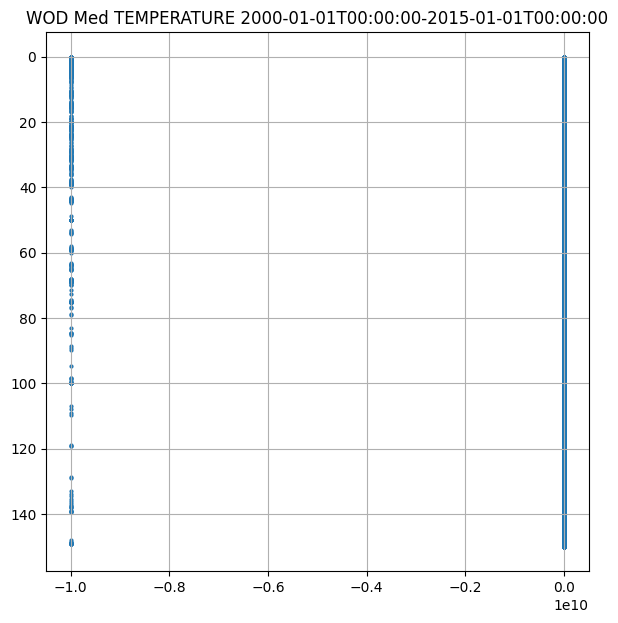

In [8]:
import matplotlib.pyplot as plt
parameter = "TEMPERATURE"
data=df[parameter]
# Check lowbound and highbound 
# 
m=min(data)
M=max(data)
print(m,M)
#
fig = plt.figure(figsize=(7,7))
sc=plt.scatter(data=df, x=parameter, y='DEPTH', s=4)
ax = plt.gca()
#plt.xlim((35.6,36.62))
#plt.ylim((995,1005))
ax.set_ylim(ax.get_ylim()[::-1])
plt.grid()
plt.title(f"{BDI} {regionname} {parameter} {mindate}-{maxdate}")
plt.show()

In [9]:
# if you want to remove out of range values
highbound = 32
lowbound = 0
df = df.loc[(df[f"{parameter}"] < highbound) & (df[f"{parameter}"] > lowbound)]

8.319000244140625 30.68199920654297


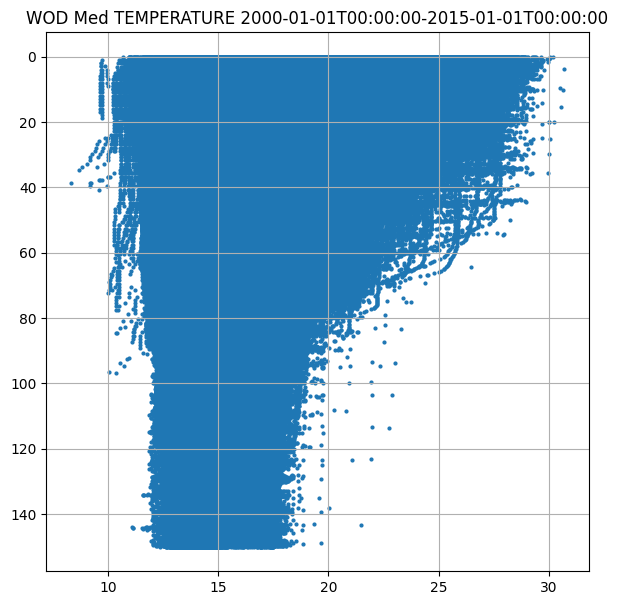

In [10]:
# Check after removing out of range values 
data=df[parameter]
m=min(data)
M=max(data)
print(m,M)
# 
fig = plt.figure(figsize=(7,7))
sc=plt.scatter(data=df, x=parameter, y='DEPTH', s=4)
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])
plt.grid()
plt.title(f"{BDI} {regionname} {parameter} {mindate}-{maxdate}")
plt.show()

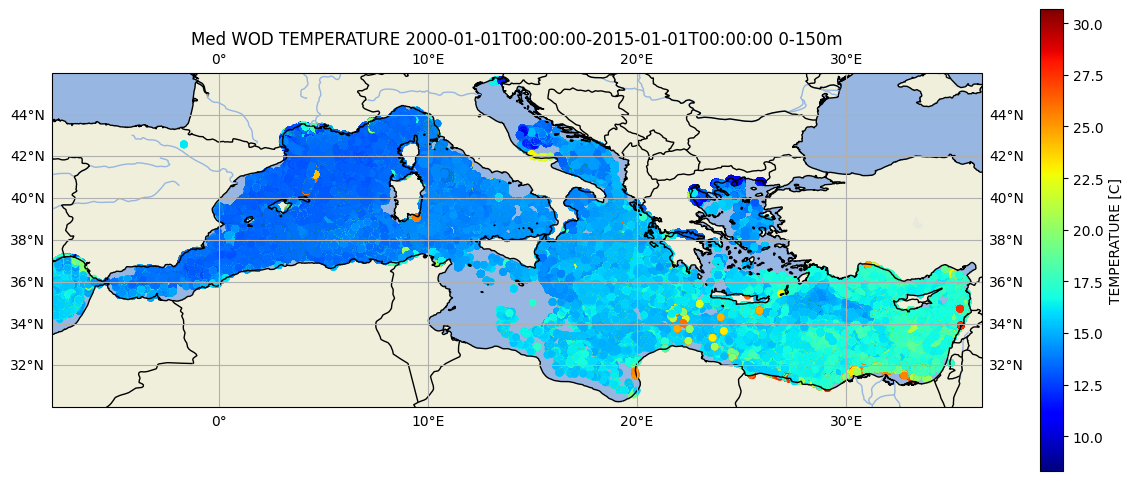

In [11]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([minlon, maxlon, minlat, maxlat], crs=ccrs.PlateCarree())  # (west, east, south, north)

ax.coastlines(resolution="10m")
ax.gridlines(draw_labels=True)

sc = ax.scatter(df["LONGITUDE"], df["LATITUDE"], c=df[parameter], cmap="jet", s=20, transform=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.RIVERS)     
ax.add_feature(cfeature.BORDERS)   
ax.add_feature(cfeature.LAKES, alpha=0.1) 

cbar = plt.colorbar(sc, ax=ax, orientation="vertical", shrink=0.6)
cbar.set_label(f"{parameter} [C]")

plt.title(f"{regionname} {BDI} {parameter} {mindate}-{maxdate} {mindepth}-{maxdepth}m")

plt.show()

-10000000000.0 40.0


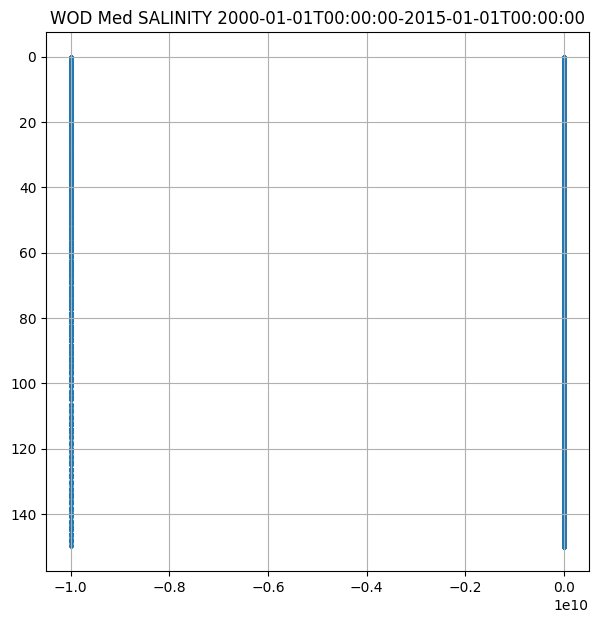

In [12]:
parameter = "SALINITY"
data=df[parameter]
m=min(data)
M=max(data)
print(m,M)
#
fig = plt.figure(figsize=(7,7))
sc=plt.scatter(data=df, x=parameter, y='DEPTH', s=4)
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])
plt.grid()
plt.title(f"{BDI} {regionname} {parameter} {mindate}-{maxdate}")
plt.show()

In [13]:
highbound = 40
lowbound = 10
df = df.loc[(df[f"{parameter}"] < highbound) & (df[f"{parameter}"] > lowbound)]

11.170968055725098 39.999794006347656


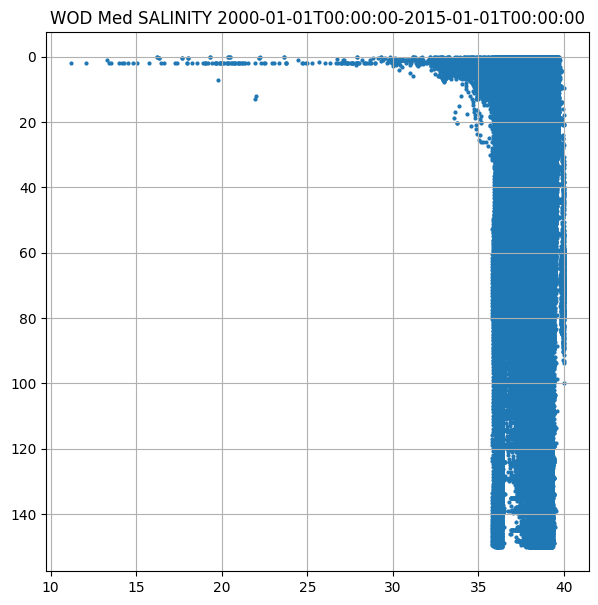

In [14]:
# Chech after removal of out of range values
data=df[parameter]
m=min(data)
M=max(data)
print(m,M)
#
fig = plt.figure(figsize=(7,7))
sc=plt.scatter(data=df, x=parameter, y='DEPTH', s=4)
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])
plt.grid()
plt.title(f"{BDI} {regionname} {parameter} {mindate}-{maxdate}")
plt.show()

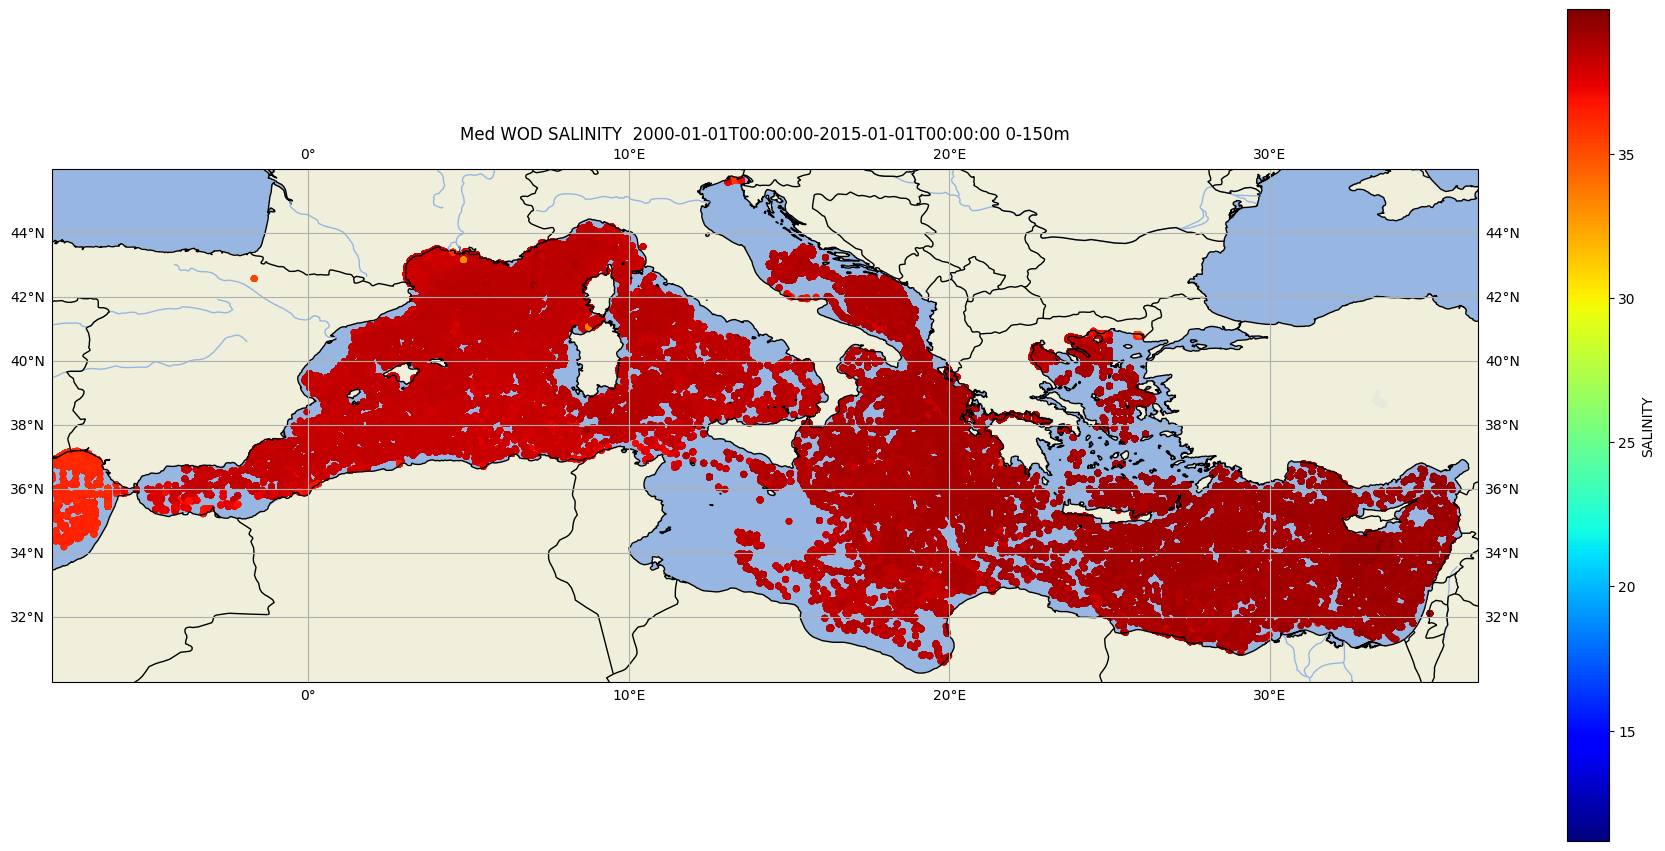

In [15]:
fig = plt.figure(figsize=(23, 18))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([minlon, maxlon, minlat, maxlat], crs=ccrs.PlateCarree())  # (west, east, south, north)

ax.coastlines(resolution="10m")
ax.gridlines(draw_labels=True)

sc = ax.scatter(df["LONGITUDE"], df["LATITUDE"], c=df[parameter], cmap="jet", s=15, transform=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.RIVERS)     
ax.add_feature(cfeature.BORDERS)   
ax.add_feature(cfeature.LAKES, alpha=0.1) 

cbar = plt.colorbar(sc, ax=ax, orientation="vertical", shrink=0.6)
cbar.set_label(f"{parameter}")

plt.title(f"{regionname} {BDI} {parameter}  {mindate}-{maxdate} {mindepth}-{maxdepth}m")

plt.show()

In [16]:
print(df["TIME"])

0         2000-03-09 23:20:00.004
1         2000-03-09 23:20:00.004
2         2000-03-09 23:20:00.004
3         2000-03-09 23:20:00.004
4         2000-03-09 23:20:00.004
                    ...          
4029926   2014-12-08 03:08:27.240
4029927   2014-12-08 03:08:27.240
4029928   2014-12-08 03:08:27.240
4029929   2014-12-08 03:08:27.240
4029930   2014-12-08 03:08:27.240
Name: TIME, Length: 3973830, dtype: datetime64[ms]


In [17]:
df['TIME2'] = pd.to_datetime(df['TIME'], unit='s')
print(df["TIME2"])
df["YEAR"]=df["TIME2"].dt.strftime('%Y')

0         2000-03-09 23:20:00.004
1         2000-03-09 23:20:00.004
2         2000-03-09 23:20:00.004
3         2000-03-09 23:20:00.004
4         2000-03-09 23:20:00.004
                    ...          
4029926   2014-12-08 03:08:27.240
4029927   2014-12-08 03:08:27.240
4029928   2014-12-08 03:08:27.240
4029929   2014-12-08 03:08:27.240
4029930   2014-12-08 03:08:27.240
Name: TIME2, Length: 3973830, dtype: datetime64[ms]


In [18]:
print(df["YEAR"])

0          2000
1          2000
2          2000
3          2000
4          2000
           ... 
4029926    2014
4029927    2014
4029928    2014
4029929    2014
4029930    2014
Name: YEAR, Length: 3973830, dtype: object


In [19]:
df

,wod_unique_cast,PLATFORM,INSTITUTE,TEMPERATURE,TEMPERATURE_QC,TEMPERATURE_PRQC,SALINITY,SALINITY_QC,SALINITY_PRQC,DEPTH,DEPTH_QC,TIME,time.units,LONGITUDE,LATITUDE,DATASET,WMO_UNIQUE_CAST,TIME2,YEAR
0,13675560,AEGAEO (R/V;call sign SXYY;built 12.1985;ex.AE...,HELLENIC CENTRE FOR MARINE RESEARCH (HCMR); fo...,10.5930,0,0,36.831001,0,0,0.992261,0,2000-03-09 23:20:00.004,days since 1770-01-01 00:00:00,24.400000,40.830002,CTD,NaN,2000-03-09 23:20:00.004,2000
1,13675560,AEGAEO (R/V;call sign SXYY;built 12.1985;ex.AE...,HELLENIC CENTRE FOR MARINE RESEARCH (HCMR); fo...,10.5940,0,0,36.831001,0,0,1.984517,0,2000-03-09 23:20:00.004,days since 1770-01-01 00:00:00,24.400000,40.830002,CTD,NaN,2000-03-09 23:20:00.004,2000
2,13675560,AEGAEO (R/V;call sign SXYY;built 12.1985;ex.AE...,HELLENIC CENTRE FOR MARINE RESEARCH (HCMR); fo...,10.5930,0,0,36.832001,0,0,2.976768,0,2000-03-09 23:20:00.004,days since 1770-01-01 00:00:00,24.400000,40.830002,CTD,NaN,2000-03-09 23:20:00.004,2000
3,13675560,AEGAEO (R/V;call sign SXYY;built 12.1985;ex.AE...,HELLENIC CENTRE FOR MARINE RESEARCH (HCMR); fo...,10.5730,0,0,36.832001,0,0,3.969014,0,2000-03-09 23:20:00.004,days since 1770-01-01 00:00:00,24.400000,40.830002,CTD,NaN,2000-03-09 23:20:00.004,2000
4,13675560,AEGAEO (R/V;call sign SXYY;built 12.1985;ex.AE...,HELLENIC CENTRE FOR MARINE RESEARCH (HCMR); fo...,10.4780,0,0,36.837002,0,0,4.961255,0,2000-03-09 23:20:00.004,days since 1770-01-01 00:00:00,24.400000,40.830002,CTD,NaN,2000-03-09 23:20:00.004,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4029926,18550809,SDEEP01 (Slocum G2 glider;WMO68967;also known ...,MEDITERRANEAN INSTITUTE FOR ADVANCED STUDIES (...,13.6039,0,0,38.221760,0,0,146.271652,0,2014-12-08 03:08:27.240,days since 1770-01-01 00:00:00,3.492556,38.622589,glider,68967.0,2014-12-08 03:08:27.240,2014
4029927,18550809,SDEEP01 (Slocum G2 glider;WMO68967;also known ...,MEDITERRANEAN INSTITUTE FOR ADVANCED STUDIES (...,13.6001,0,0,38.225021,0,0,147.047775,0,2014-12-08 03:08:27.240,days since 1770-01-01 00:00:00,3.492556,38.622589,glider,68967.0,2014-12-08 03:08:27.240,2014
4029928,18550809,SDEEP01 (Slocum G2 glider;WMO68967;also known ...,MEDITERRANEAN INSTITUTE FOR ADVANCED STUDIES (...,13.5971,0,0,38.226341,0,0,147.817047,0,2014-12-08 03:08:27.240,days since 1770-01-01 00:00:00,3.492556,38.622589,glider,68967.0,2014-12-08 03:08:27.240,2014
4029929,18550809,SDEEP01 (Slocum G2 glider;WMO68967;also known ...,MEDITERRANEAN INSTITUTE FOR ADVANCED STUDIES (...,13.5945,0,0,38.227264,0,0,148.583832,0,2014-12-08 03:08:27.240,days since 1770-01-01 00:00:00,3.492556,38.622589,glider,68967.0,2014-12-08 03:08:27.240,2014


In [20]:
df.shape

(3973830, 19)

In [21]:
df.count()

wod_unique_cast     3973830
PLATFORM            2680533
INSTITUTE           2668636
TEMPERATURE         3973830
TEMPERATURE_QC      3973830
TEMPERATURE_PRQC    3973830
SALINITY            3973830
SALINITY_QC         3973830
SALINITY_PRQC       3973830
DEPTH               3973830
DEPTH_QC            3973830
TIME                3973830
time.units          3973830
LONGITUDE           3973830
LATITUDE            3973830
DATASET             3973830
WMO_UNIQUE_CAST     3553032
TIME2               3973830
YEAR                3973830
dtype: int64

In [22]:
list(df.columns)

['wod_unique_cast',
 'PLATFORM',
 'INSTITUTE',
 'TEMPERATURE',
 'TEMPERATURE_QC',
 'TEMPERATURE_PRQC',
 'SALINITY',
 'SALINITY_QC',
 'SALINITY_PRQC',
 'DEPTH',
 'DEPTH_QC',
 'TIME',
 'time.units',
 'LONGITUDE',
 'LATITUDE',
 'DATASET',
 'WMO_UNIQUE_CAST',
 'TIME2',
 'YEAR']

In [23]:
df.filter(["Platform"]).drop_duplicates()

""
0
1
2
3
4
...
4029926
4029927
4029928
4029929


In [24]:
df.filter(["Institute"]).drop_duplicates()

""
0
1
2
3
4
...
4029926
4029927
4029928
4029929


In [25]:
df.filter(["DATASET"]).drop_duplicates()

,DATASET
0,CTD
24832,glider
66007,profiling float
189791,moored buoy
1054822,XCTD
1300522,bottle/rosette/net


In [26]:
df.describe().round(2)

,wod_unique_cast,TEMPERATURE,TEMPERATURE_QC,TEMPERATURE_PRQC,SALINITY,SALINITY_QC,SALINITY_PRQC,DEPTH,DEPTH_QC,TIME,LONGITUDE,LATITUDE,WMO_UNIQUE_CAST,TIME2
count,3973830.00,3973830.00,3973830.0,3973830.0,3973830.00,3973830.0,3973830.0,3973830.00,3973830.0,3973830,3973830.00,3973830.00,3553032.00,3973830
mean,16769935.45,14.96,0.0,0.0,38.25,0.0,0.0,66.95,0.0,2010-12-31 17:46:15.965000,8.75,40.87,2444616.73,2010-12-31 17:46:15.965000
min,9874372.00,8.32,0.0,0.0,11.17,0.0,0.0,0.00,0.0,2000-01-20 14:51:59.998000,-8.00,30.61,18956.00,2000-01-20 14:51:59.998000
25%,15465129.00,13.31,0.0,0.0,38.07,0.0,0.0,29.65,0.0,2008-09-01 09:56:16.439000,3.73,39.02,68950.00,2008-09-01 09:56:16.439000
50%,16562058.00,13.94,0.0,0.0,38.28,0.0,0.0,63.21,0.0,2011-12-15 02:20:38.040000,6.32,42.20,68953.00,2011-12-15 02:20:38.040000
75%,19307218.00,15.49,0.0,0.0,38.48,0.0,0.0,101.81,0.0,2013-11-05 09:56:16.439000,10.54,42.88,6900679.00,2013-11-05 09:56:16.439000
max,22511616.00,30.68,0.0,0.0,40.00,0.0,0.0,150.00,0.0,2015-01-01 00:00:00,35.84,45.65,6903022.00,2015-01-01 00:00:00
std,2970172.34,2.62,0.0,0.0,0.49,0.0,0.0,42.79,0.0,NaN,7.49,2.79,3189105.37,NaN


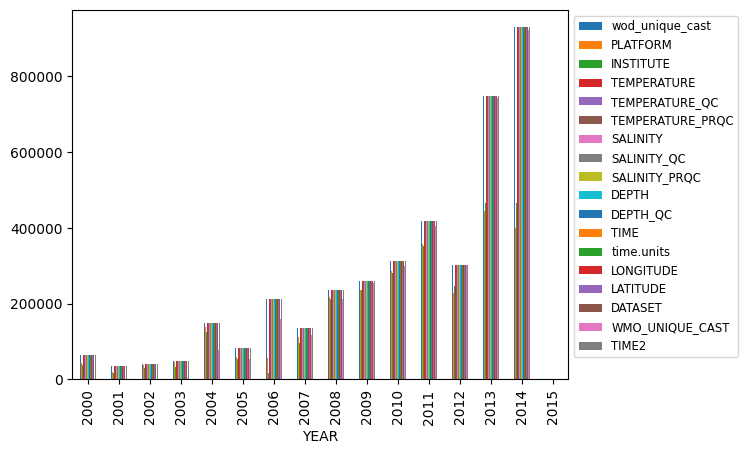

In [27]:
df.groupby(df["YEAR"]).count().plot(kind="bar").legend(loc='best')  # loc='best' / loc='lower left'
plt.legend(fontsize='small',bbox_to_anchor=(1.0, 1.0))

In [29]:
df2=df[["YEAR","PLATFORM"]]

<Axes: xlabel='YEAR'>

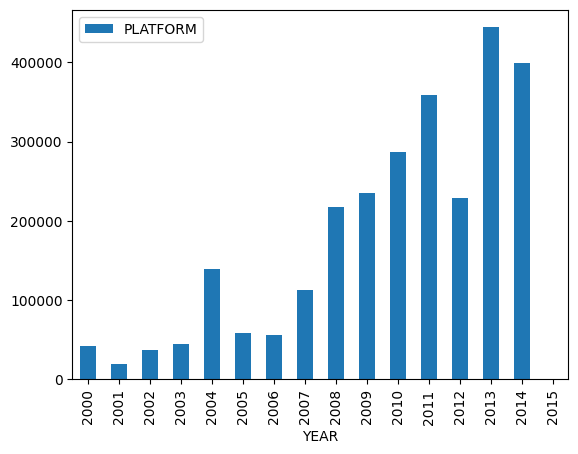

In [30]:
df2.groupby(df2["YEAR"]).count().plot(kind="bar")

In [32]:
# Have a look on number of measurement of paltform_number by year
import pandas as pd
pd.crosstab(df.YEAR,df.PLATFORM)

PLATFORM,AEGAEO (R/V;call sign SXYY;built 12.1985;ex.AEGAIO 10.1994;IMO8412429),AL AMIR MOULAY ABDALLAH (R/V;built 2001;length 38.5;IMO9242510)\0,AMERIGO (Seaglider;WMO6800166;alt.name SG554;operated by OGS),AMMONITE (AUV;Slocum glider #038;WMO 68983;operated by UK MARS facility)a,BEAUTEMPS-BEAUPRE (A758; call sign FABB; built 2001),BELLAMITE (AUV;Slocum glider #051;b.2006;WMO 68972;oper.by UK MARS facility),BONPLAND (AUV;Slocum glider #142;owned by LOCEAN),CAMPE (AUV;Slocum glider;#176;b.2009;Length 2.15;owned by the IFREMER),CHARLES DARWIN (R/V;c.s.GDLS;built 1984;ren-d Ocean Researcher 2006;IMO8207941),COPROLITE (AUV;Slocum glider #052;WMO 68973;b.2006;owned by NOC),...,SG509 (Seaglider #509;WMO 68456;b.2009;also known as Baker;owned by INSU/CNRS)\0,SOCIB (Catamaran;call sign EABV;R/V;built 09.2012;length 23.76),TENUSE (AUV;Slocum glider;#173;b.2009;Length 2.15;owned by the IFREMER),TETHYS II (R/V; call sign FGTO; built 1993; IMO9066007),THALASSA (Call sign FNFP; built 12/1995; IMO9070307),THEQUE (Slocum glider;WMO 68453;operated by INSU/CNRS),TINTIN (AUV;Slocum glider;#124;b.2008;Length 2.15;owned by ESA),TRIESTE-1 (Shallow Slocum glider;WMO61865;operated by OGS;lost 12.2009)\0,URANIA (Call sign IQSU),WALLIS (AUV;Slocum glider #135;owned by INSU)
YEAR,,,,,,,,,,,,,,,,,,,,,
2000,32315,0,0,0,0,0,0,0,0,0,...,0,0,0,8265,0,0,0,0,0,0
2001,7859,0,0,0,0,0,0,0,0,0,...,0,0,0,6839,0,0,0,0,529,0
2002,4926,0,0,0,0,0,0,0,0,0,...,0,0,0,21749,3471,0,0,0,1800,0
2003,1427,0,0,0,0,0,0,0,0,0,...,0,0,0,40354,0,0,0,0,1198,0
2004,854,0,0,0,0,0,0,0,0,0,...,0,0,0,25962,37396,0,0,0,4492,0
2005,3515,15,0,0,0,0,0,0,7,0,...,0,0,0,26154,0,0,0,0,0,0
2006,6120,20,0,0,1598,0,0,0,0,0,...,0,0,0,14638,0,0,0,0,0,0
2007,0,23,0,12357,141,4662,0,0,0,7407,...,0,0,0,18001,0,0,0,0,0,0
2008,0,0,0,12035,1860,13392,0,0,0,12872,...,0,0,0,16508,0,0,2939,0,1641,0


In [33]:
#### Display stations sorted by year
yymin = min(df["YEAR"].apply(pd.to_numeric))-1
yymax = max(df["YEAR"].apply(pd.to_numeric))+1

In [34]:
#mindate = "2000-01-01"  # yyyy-mm-dd
#maxdate = "2015-01-01"  # yyyy-mm-dd
print(yymin), print(yymax)

1999
2016


(None, None)

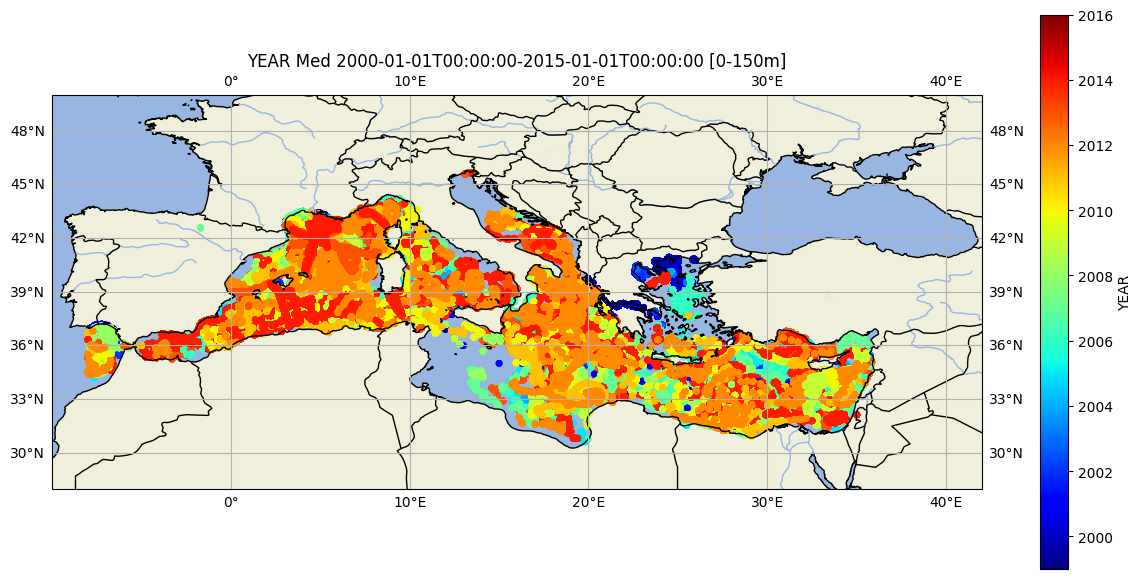

In [35]:
fig = plt.figure(figsize=(15, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-10, 42, 28, 50], crs=ccrs.PlateCarree())  # (west, east, south, north)
ax.coastlines(resolution="10m")
ax.gridlines(draw_labels=True)

#sc = ax.scatter(df["LONGITUDE"], df["LATITUDE"], c=df["TEMP"], cmap="viridis", s=15, transform=ccrs.PlateCarree())
#sc = ax.scatter(df_filter["LONGITUDE"], df_filter["LATITUDE"], c=df_filter["Year"], cmap="jet", s=15, transform=ccrs.PlateCarree())
sc = ax.scatter(df["LONGITUDE"], df["LATITUDE"], c=df["YEAR"].apply(pd.to_numeric), cmap="jet", s=15, transform=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.RIVERS)     
ax.add_feature(cfeature.BORDERS)   
ax.add_feature(cfeature.LAKES, alpha=0.1) 

cbar = plt.colorbar(sc, ax=ax, orientation="vertical", shrink=0.6, label="Value Set 1")
cbar.set_label(f"{'YEAR'}")
cbar.mappable.set_clim(yymin,yymax)

plt.title(f"{'YEAR'} {regionname} {mindate}-{maxdate} [{mindepth}-{maxdepth}m]")

plt.show()

In [36]:
#### Display profiles
df

,wod_unique_cast,PLATFORM,INSTITUTE,TEMPERATURE,TEMPERATURE_QC,TEMPERATURE_PRQC,SALINITY,SALINITY_QC,SALINITY_PRQC,DEPTH,DEPTH_QC,TIME,time.units,LONGITUDE,LATITUDE,DATASET,WMO_UNIQUE_CAST,TIME2,YEAR
0,13675560,AEGAEO (R/V;call sign SXYY;built 12.1985;ex.AE...,HELLENIC CENTRE FOR MARINE RESEARCH (HCMR); fo...,10.5930,0,0,36.831001,0,0,0.992261,0,2000-03-09 23:20:00.004,days since 1770-01-01 00:00:00,24.400000,40.830002,CTD,NaN,2000-03-09 23:20:00.004,2000
1,13675560,AEGAEO (R/V;call sign SXYY;built 12.1985;ex.AE...,HELLENIC CENTRE FOR MARINE RESEARCH (HCMR); fo...,10.5940,0,0,36.831001,0,0,1.984517,0,2000-03-09 23:20:00.004,days since 1770-01-01 00:00:00,24.400000,40.830002,CTD,NaN,2000-03-09 23:20:00.004,2000
2,13675560,AEGAEO (R/V;call sign SXYY;built 12.1985;ex.AE...,HELLENIC CENTRE FOR MARINE RESEARCH (HCMR); fo...,10.5930,0,0,36.832001,0,0,2.976768,0,2000-03-09 23:20:00.004,days since 1770-01-01 00:00:00,24.400000,40.830002,CTD,NaN,2000-03-09 23:20:00.004,2000
3,13675560,AEGAEO (R/V;call sign SXYY;built 12.1985;ex.AE...,HELLENIC CENTRE FOR MARINE RESEARCH (HCMR); fo...,10.5730,0,0,36.832001,0,0,3.969014,0,2000-03-09 23:20:00.004,days since 1770-01-01 00:00:00,24.400000,40.830002,CTD,NaN,2000-03-09 23:20:00.004,2000
4,13675560,AEGAEO (R/V;call sign SXYY;built 12.1985;ex.AE...,HELLENIC CENTRE FOR MARINE RESEARCH (HCMR); fo...,10.4780,0,0,36.837002,0,0,4.961255,0,2000-03-09 23:20:00.004,days since 1770-01-01 00:00:00,24.400000,40.830002,CTD,NaN,2000-03-09 23:20:00.004,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4029926,18550809,SDEEP01 (Slocum G2 glider;WMO68967;also known ...,MEDITERRANEAN INSTITUTE FOR ADVANCED STUDIES (...,13.6039,0,0,38.221760,0,0,146.271652,0,2014-12-08 03:08:27.240,days since 1770-01-01 00:00:00,3.492556,38.622589,glider,68967.0,2014-12-08 03:08:27.240,2014
4029927,18550809,SDEEP01 (Slocum G2 glider;WMO68967;also known ...,MEDITERRANEAN INSTITUTE FOR ADVANCED STUDIES (...,13.6001,0,0,38.225021,0,0,147.047775,0,2014-12-08 03:08:27.240,days since 1770-01-01 00:00:00,3.492556,38.622589,glider,68967.0,2014-12-08 03:08:27.240,2014
4029928,18550809,SDEEP01 (Slocum G2 glider;WMO68967;also known ...,MEDITERRANEAN INSTITUTE FOR ADVANCED STUDIES (...,13.5971,0,0,38.226341,0,0,147.817047,0,2014-12-08 03:08:27.240,days since 1770-01-01 00:00:00,3.492556,38.622589,glider,68967.0,2014-12-08 03:08:27.240,2014
4029929,18550809,SDEEP01 (Slocum G2 glider;WMO68967;also known ...,MEDITERRANEAN INSTITUTE FOR ADVANCED STUDIES (...,13.5945,0,0,38.227264,0,0,148.583832,0,2014-12-08 03:08:27.240,days since 1770-01-01 00:00:00,3.492556,38.622589,glider,68967.0,2014-12-08 03:08:27.240,2014


In [37]:
d_D_n = df['DEPTH']
d_T_n = df['TEMPERATURE']
d_S_n = df['SALINITY']
QC_T = pd.to_numeric(df['TEMPERATURE_QC'])
QC_S = pd.to_numeric(df['SALINITY_QC'])

In [38]:
# Function to map the colors as a list from the input list of x variables
# In this query only QC1 have been exported
def pltcolor(lst):
    cols=[]
    for l in lst:
        if l==1:
            cols.append('green')
        elif l==2:
            cols.append('yellow')
        elif l==3:
            cols.append('orange')    
        else:
            cols.append('red')
    return cols
# Create the colors list using the function above
cols_T=pltcolor(QC_T)
cols_S=pltcolor(QC_S)

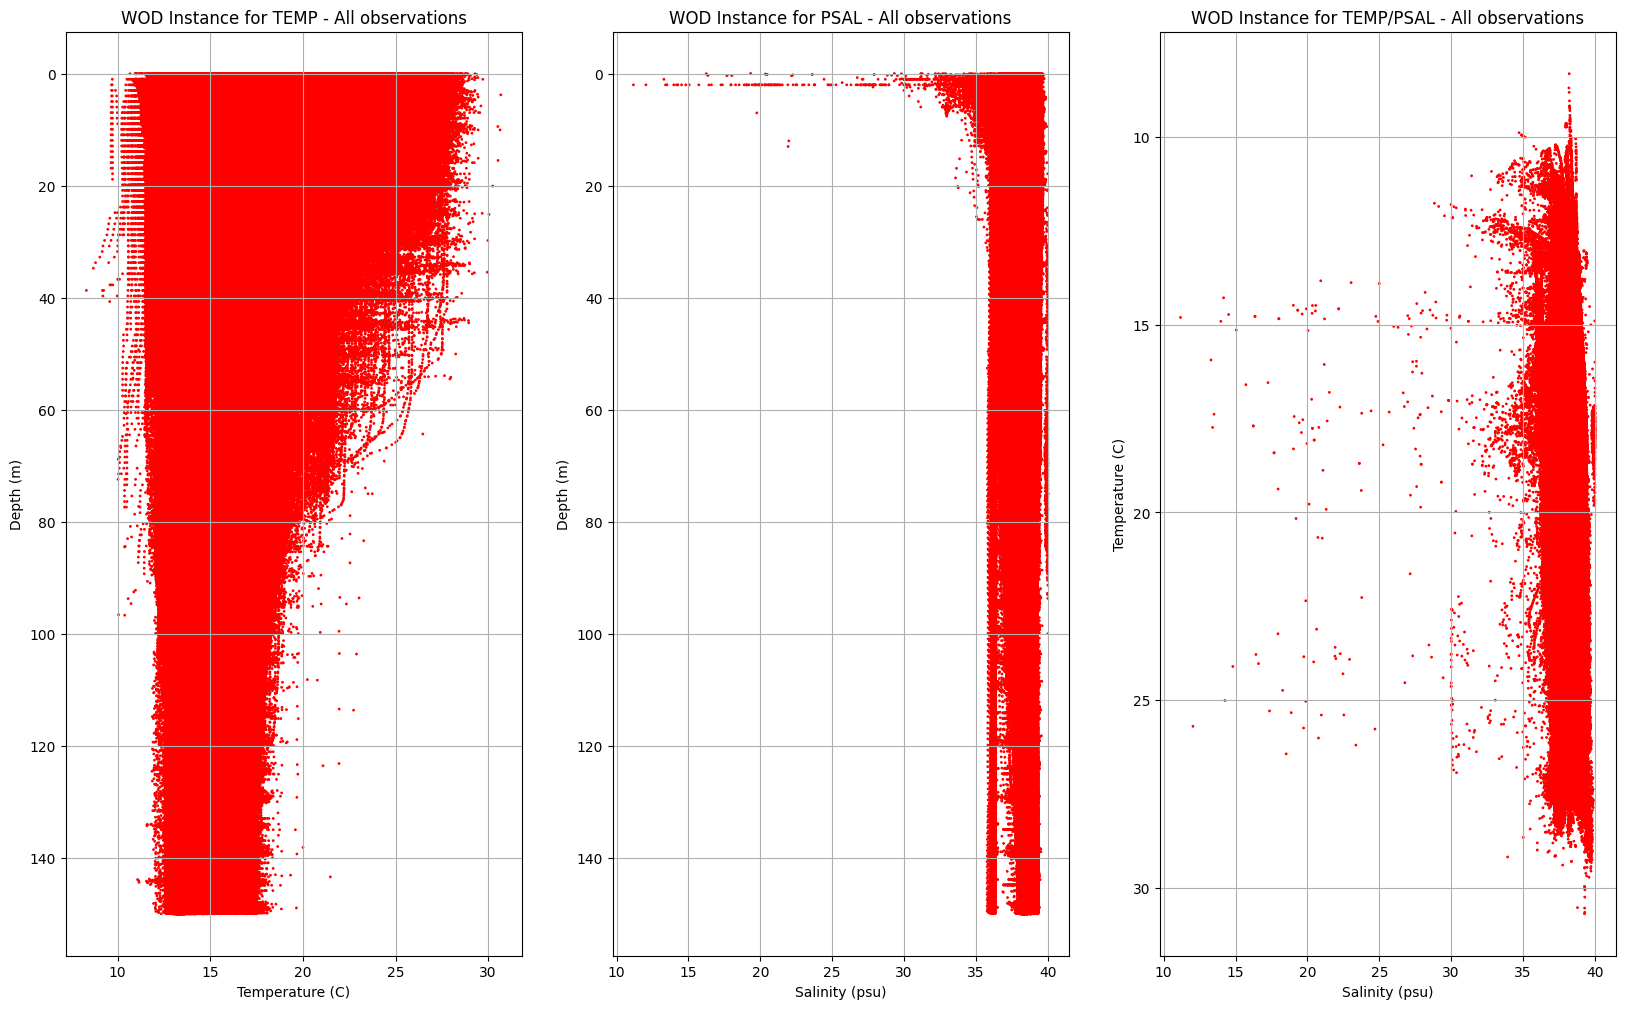

In [39]:
plt.figure(figsize=(20, 12))
plt.subplot(1,3,1)
plt.scatter(x=d_T_n, y=d_D_n, s=1, c=cols_T)
plt.xlabel('Temperature (C)')
plt.ylabel('Depth (m)')
plt.title('WOD Instance for TEMP - All observations')
plt.gca().invert_yaxis() #Flip the y-axis
plt.grid()
plt.subplot(1,3,2)
plt.scatter(x=d_S_n, y=d_D_n, s=1, c=cols_S)
plt.xlabel('Salinity (psu)')
plt.ylabel('Depth (m)')
plt.title('WOD Instance for PSAL - All observations')
plt.gca().invert_yaxis() #Flip the y-axis
plt.grid()
plt.subplot(1,3,3)
plt.scatter(x=d_S_n, y=d_T_n, s=1, c=cols_S)
plt.xlabel('Salinity (psu)')
plt.ylabel('Temperature (C)')
plt.title('WOD Instance for TEMP/PSAL - All observations')
plt.gca().invert_yaxis() #Flip the y-axis
plt.grid()

In [40]:
#pandas.DataFrame.dtypes
#df.Platform.dtype
df.DATASET.dtype

dtype('O')

In [41]:
#WMO= '1900602'
#df_WMO = df[df["PLATFORM_NUMBER"].astype(float) == 1900602]

DATASET= 'glider'
df_DATASET = df[df["DATASET"] == "glider"]

In [42]:
df_DATASET

,wod_unique_cast,PLATFORM,INSTITUTE,TEMPERATURE,TEMPERATURE_QC,TEMPERATURE_PRQC,SALINITY,SALINITY_QC,SALINITY_PRQC,DEPTH,DEPTH_QC,TIME,time.units,LONGITUDE,LATITUDE,DATASET,WMO_UNIQUE_CAST,TIME2,YEAR
24832,10875281,IFM01 (AUV;Slocum glider #031;owned by IFM-GEO...,LEIBNIZ INSTITUT FUR MEERESWISSENSCHAFTEN (IFM...,23.329500,0,0,38.602192,0,0,22.729185,0,2004-10-08 00:45:00.000,days since 1770-01-01 00:00:00,16.715017,37.110924,glider,6200595.0,2004-10-08 00:45:00.000,2004
24833,10875281,IFM01 (AUV;Slocum glider #031;owned by IFM-GEO...,LEIBNIZ INSTITUT FUR MEERESWISSENSCHAFTEN (IFM...,19.100100,0,0,38.254253,0,0,31.542269,0,2004-10-08 00:45:00.000,days since 1770-01-01 00:00:00,16.715017,37.110924,glider,6200595.0,2004-10-08 00:45:00.000,2004
24834,10875281,IFM01 (AUV;Slocum glider #031;owned by IFM-GEO...,LEIBNIZ INSTITUT FUR MEERESWISSENSCHAFTEN (IFM...,18.129601,0,0,38.790478,0,0,40.454205,0,2004-10-08 00:45:00.000,days since 1770-01-01 00:00:00,16.715017,37.110924,glider,6200595.0,2004-10-08 00:45:00.000,2004
24835,10875281,IFM01 (AUV;Slocum glider #031;owned by IFM-GEO...,LEIBNIZ INSTITUT FUR MEERESWISSENSCHAFTEN (IFM...,16.433500,0,0,38.804653,0,0,47.212345,0,2004-10-08 00:45:00.000,days since 1770-01-01 00:00:00,16.715017,37.110924,glider,6200595.0,2004-10-08 00:45:00.000,2004
24836,10875281,IFM01 (AUV;Slocum glider #031;owned by IFM-GEO...,LEIBNIZ INSTITUT FUR MEERESWISSENSCHAFTEN (IFM...,15.808500,0,0,38.696812,0,0,52.442047,0,2004-10-08 00:45:00.000,days since 1770-01-01 00:00:00,16.715017,37.110924,glider,6200595.0,2004-10-08 00:45:00.000,2004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4029926,18550809,SDEEP01 (Slocum G2 glider;WMO68967;also known ...,MEDITERRANEAN INSTITUTE FOR ADVANCED STUDIES (...,13.603900,0,0,38.221760,0,0,146.271652,0,2014-12-08 03:08:27.240,days since 1770-01-01 00:00:00,3.492556,38.622589,glider,68967.0,2014-12-08 03:08:27.240,2014
4029927,18550809,SDEEP01 (Slocum G2 glider;WMO68967;also known ...,MEDITERRANEAN INSTITUTE FOR ADVANCED STUDIES (...,13.600100,0,0,38.225021,0,0,147.047775,0,2014-12-08 03:08:27.240,days since 1770-01-01 00:00:00,3.492556,38.622589,glider,68967.0,2014-12-08 03:08:27.240,2014
4029928,18550809,SDEEP01 (Slocum G2 glider;WMO68967;also known ...,MEDITERRANEAN INSTITUTE FOR ADVANCED STUDIES (...,13.597100,0,0,38.226341,0,0,147.817047,0,2014-12-08 03:08:27.240,days since 1770-01-01 00:00:00,3.492556,38.622589,glider,68967.0,2014-12-08 03:08:27.240,2014
4029929,18550809,SDEEP01 (Slocum G2 glider;WMO68967;also known ...,MEDITERRANEAN INSTITUTE FOR ADVANCED STUDIES (...,13.594500,0,0,38.227264,0,0,148.583832,0,2014-12-08 03:08:27.240,days since 1770-01-01 00:00:00,3.492556,38.622589,glider,68967.0,2014-12-08 03:08:27.240,2014


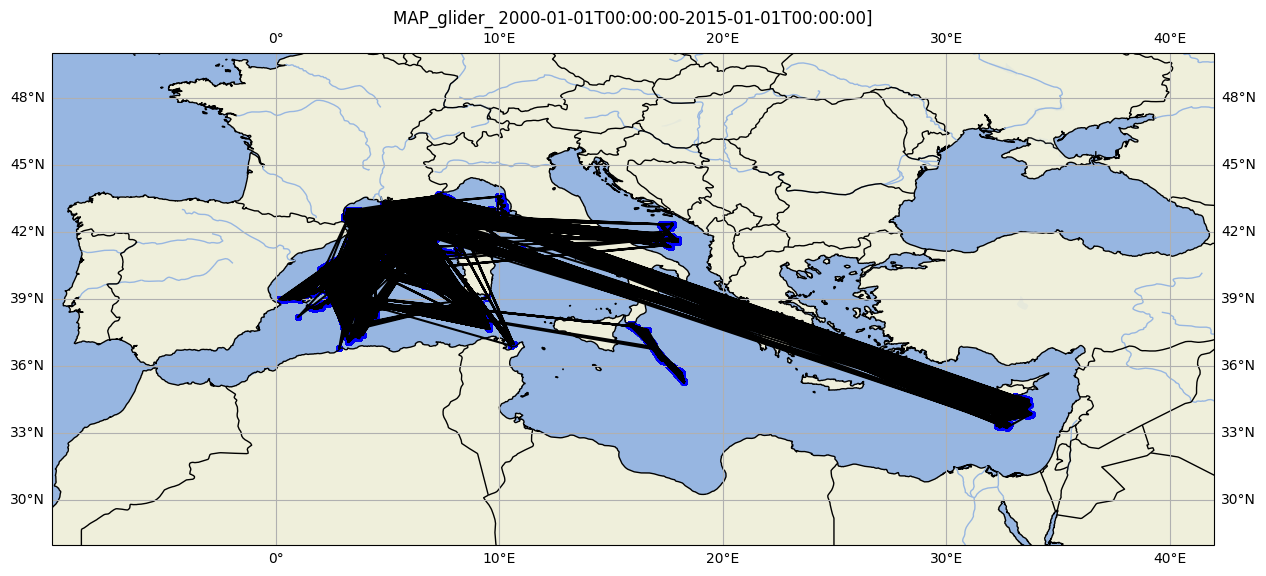

In [43]:
fig = plt.figure(figsize=(15, 12))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-10, 42, 28, 50], crs=ccrs.PlateCarree())  # (west, east, south, north)
ax.coastlines(resolution="10m")
ax.gridlines(draw_labels=True)

sc = ax.scatter(df_DATASET["LONGITUDE"], df_DATASET["LATITUDE"], c='b', s=12, transform=ccrs.PlateCarree())
#pltt = ax.plot(df_DATASET["LONGITUDE"], df_DATASET["LATITUDE"],'k-')
pltt = ax.plot(df_DATASET["LONGITUDE"], df_DATASET["LATITUDE"],'k')

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.RIVERS)     
ax.add_feature(cfeature.BORDERS)   
ax.add_feature(cfeature.LAKES, alpha=0.1) 

plt.title(f"MAP_{DATASET}_ {mindate}-{maxdate}]")

plt.show()

In [44]:
d_D_n = df_DATASET['DEPTH']
d_T_n = df_DATASET['TEMPERATURE']
d_S_n = df_DATASET['SALINITY']
QC_T = pd.to_numeric(df_DATASET['TEMPERATURE_QC'])
QC_S = pd.to_numeric(df_DATASET['SALINITY_QC'])

In [45]:
# Function to map the colors as a list from the input list of x variables
def pltcolor(lst):
    cols=[]
    for l in lst:
        if l==1:
            cols.append('green')
        elif l==2:
            cols.append('yellow')
        elif l==3:
            cols.append('orange')    
        else:
            cols.append('red')
    return cols
# Create the colors list using the function above
cols_T=pltcolor(QC_T)
cols_S=pltcolor(QC_S)

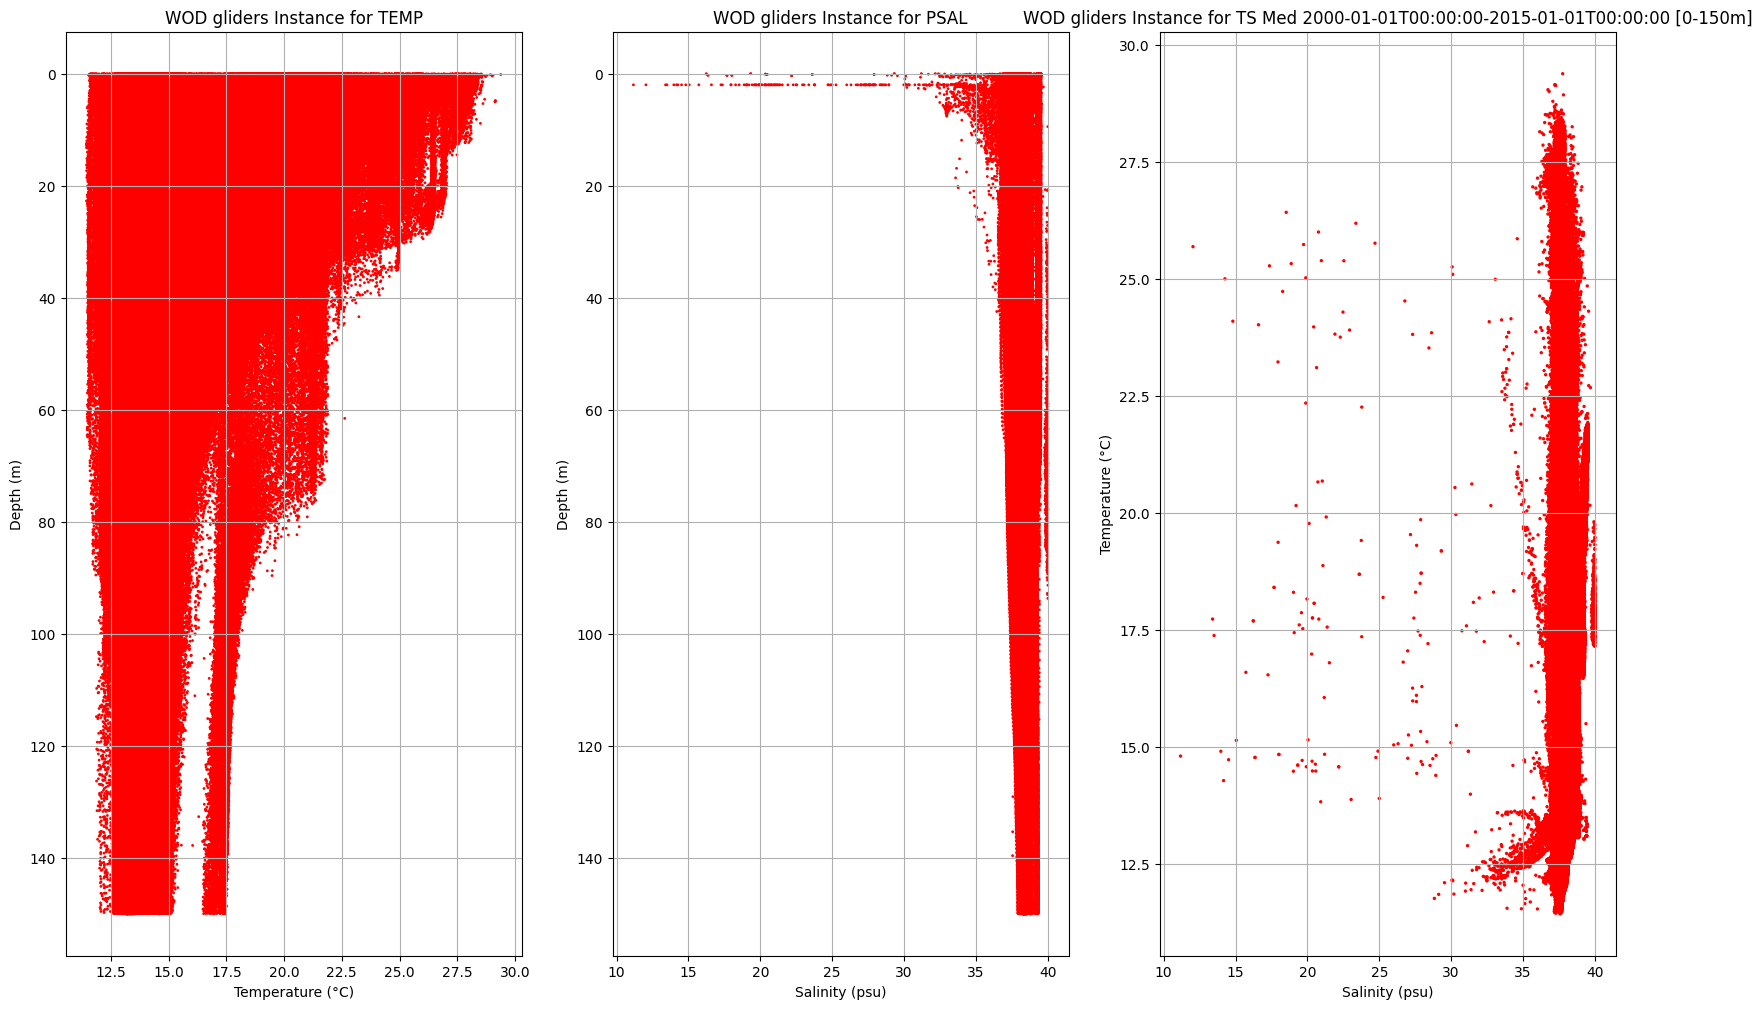

In [46]:
plt.figure(figsize=(20, 12))
plt.subplot(1,3,1)
plt.scatter(x=d_T_n, y=d_D_n, s=1, c=cols_T)
plt.xlabel('Temperature (°C)')
plt.ylabel('Depth (m)')
plt.title('WOD gliders Instance for TEMP')
plt.gca().invert_yaxis() #Flip the y-axis
plt.grid()
plt.subplot(1,3,2)
plt.scatter(x=d_S_n, y=d_D_n, s=1, c=cols_S)
plt.xlabel('Salinity (psu)')
plt.ylabel('Depth (m)')
plt.title('WOD gliders Instance for PSAL')
plt.gca().invert_yaxis() #Flip the y-axis
plt.grid()
plt.subplot(1,3,3)
plt.scatter(x=d_S_n, y=d_T_n, s=2, c=cols_S)
plt.xlabel('Salinity (psu)')
plt.ylabel('Temperature (°C)')
plt.title(f"{'WOD gliders Instance for TS'} {regionname} {mindate}-{maxdate} [{mindepth}-{maxdepth}m]")
plt.grid()

In [47]:
!pip install seawater
import seawater
import numpy as np

C:\Users\tjerk\AppData\Local\Temp\ipykernel_24272\199886286.py:2: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater


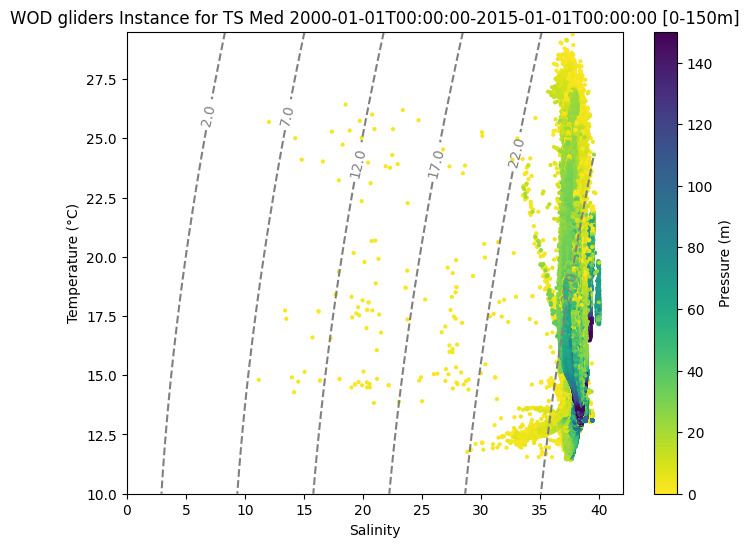

In [48]:
# TS Diagram with density contours
plt.figure(figsize=(8,6))

# Calculate the density lines
x = np.arange(0, 40, .5)
y = np.arange(10, 30, .5)
X, Y = np.meshgrid(x, y)
Z = seawater.eos80.dens0(X,Y) - 1000 # Substract 1000 to convert to sigma-t

# Plot the contour lines
CS = plt.contour(X, Y, Z, colors='grey', linestyles='dashed', levels=np.arange(2,30,5))
plt.clabel(CS, inline=1, fontsize=10, fmt='%0.1f')

# Plot the data
nprof = 2 #Selected profile
plt.scatter(d_S_n, d_T_n, c=d_D_n, cmap='viridis_r', s=4)
plt.xlabel('Salinity');
plt.ylabel('Temperature (°C)')
#plt.title(f"{'WOD gliders Instance for TS'} {DATASET} {regionname} {mindate}-{maxdate} [{mindepth}-{maxdepth}m]")
plt.title(f"{'WOD gliders Instance for TS'} {regionname} {mindate}-{maxdate} [{mindepth}-{maxdepth}m]")


# Add a colorbar
cbh = plt.colorbar(label='Pressure (m)');

C:\Users\tjerk\AppData\Local\Temp\ipykernel_24272\2255965819.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("jet") # set colormap to jet -see https://matplotlib.org/stable/users/explain/colors/colormaps.html


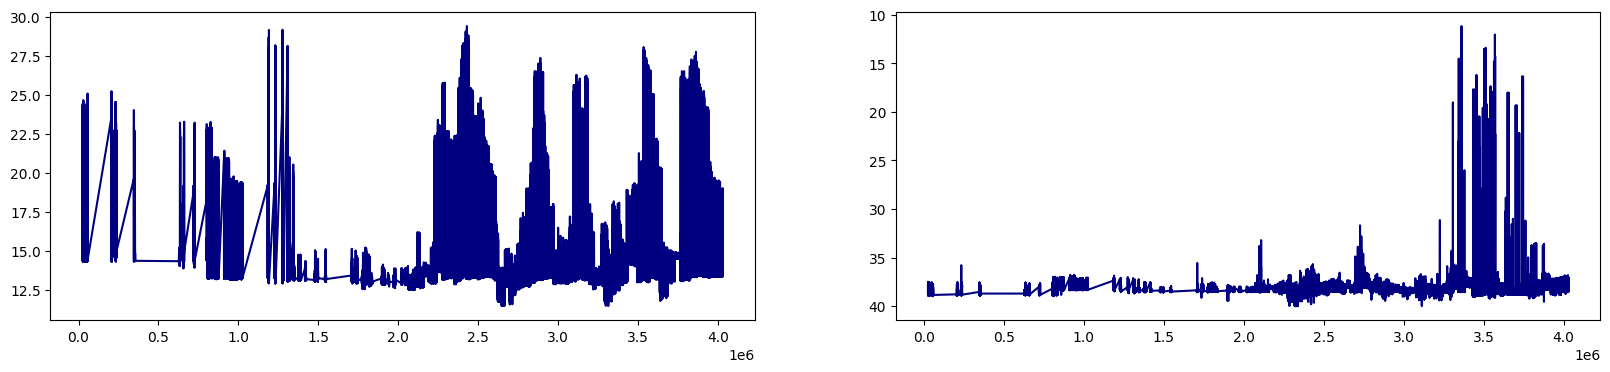

In [49]:
# Quick Timeseries Profile plot of Temperature  !! TAKE CARE DATA WITH ALL QC
plt.figure(figsize=(20, 4))  # size of the figure
cmap = plt.cm.get_cmap("jet") # set colormap to jet -see https://matplotlib.org/stable/users/explain/colors/colormaps.html
plt.subplot(1,2,1)
df_DATASET.TEMPERATURE.T.plot(cmap = cmap)
#plt.title(f"{TEMP - WOD gliders }", fontweight='bold')
plt.subplot(1,2,2)
df_DATASET.SALINITY.T.plot(cmap = cmap)
plt.gca().invert_yaxis()
#plt.title(f"{SALINITY - WOD gliders }", fontweight='bold')